# Herding

In this notebook, we plot **Figures 6(a), 6(b), and 6(c)**. To do so, we first need to create some DataFrames with the time series of the ratings.

**Requirements**:
- You need to run notebook `4-zscores` to get the file `z_score_params_matched_ratings` in `data/tmp` and the files `ratings_ba.txt.gz` and `ratings_rb.txt.gz` in `data/matched`. In other words, you need to **run the first 5 cells of `4-zscores`**.

**Benchmark time**: This notebook has been run on a Dell Latitude (ElementaryOS 0.4.1 Loki, i7-7600U, 16GB RAM).

In [1]:
import os
os.chdir('..')

In [2]:
# Helpers functions
from python.helpers import parse, flatten

# Libraries for preparing data
import ast
import json
import gzip
import numpy as np
import pandas as pd
from datetime import datetime
import scipy.stats as ss

# Libraries for plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib

# Folders
data_folder = '../data/'
fig_folder = '../figures/'

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# General info for plotting
colors = {'H for HH': '#8b0000',
          'H for HL': '#c1253d',
          'H for HM': '#e75c59',
          'M for HM': '#fe9755',
          'M for MM': '#ffd700',
          'M for LM': '#9dcd75',
          'L for LM': '#6cb482',
          'M for ML': '#9dcd75',
          'L for ML': '#6cb482',
          'L for HL': '#419a83',
          'L for LL': '#008080'}

labels = {'ba': 'BeerAdvocate', 'rb': 'RateBeer'}

min_nbr_rats = 5

# Check that folders exist
if not os.path.exists(data_folder + 'tmp'):
    os.makedirs(data_folder + 'tmp')

if not os.path.exists(data_folder + 'prepared'):
    os.makedirs(data_folder + 'prepared')
    
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

# Create the Time Series

In [3]:
%%time

# Get the matched beers
beers = pd.read_csv(data_folder + 'matched/beers.csv', header=[0,1])


# Get the matched beers with at least 10 ratings
beers = beers[(beers['ba']['nbr_ratings'] >= min_nbr_rats) & (beers['rb']['nbr_ratings'] >= min_nbr_rats)]
beers.index = range(len(beers))

# get the ratings for these beers
ratings = {'ba': {}, 'rb': {}}

# Go through BA and RB
for key in ratings.keys():
    print('Parse {} ratings'.format(key.upper()))
    # get the iterator
    gen = parse(data_folder + 'matched/ratings_{}.txt.gz'.format(key))
    
    # Go through the iterator
    for item in gen:
        
        # Get the beer_id, the rating and the date
        beer_id = item['beer_id']
        rating = item['rating']
        date = item['date']
        
        if beer_id not in ratings[key].keys():
            ratings[key][beer_id] = {'date': [], 'rating': []}
        
        # And add them
        ratings[key][beer_id]['date'].append(int(date))
        ratings[key][beer_id]['rating'].append(float(rating))

Parse BA ratings
Parse RB ratings
CPU times: user 1min 14s, sys: 248 ms, total: 1min 15s
Wall time: 1min 15s


In [4]:
%%time

# Compute the global averages
global_average = {'ba': {'rating': 0, 'z_score': 0, 'std': 0},
                  'rb': {'rating': 0, 'z_score': 0, 'std': 0}}

with open(data_folder + 'tmp/z_score_params_matched_ratings.json') as file:
    z = json.load(file)

# Go through BA and RB
for key in ratings.keys():
    all_ratings = []
    all_z_score = []
    nbr = 0
    
    # Go through all ids
    for id_ in ratings[key].keys():
        rats = ratings[key][id_]['rating']
        dates = ratings[key][id_]['date']
        
        # Get year and compute zscores
        years = [str(datetime.fromtimestamp(d).year) for d in dates]
        z_scores = [(r-z[key][y]['mean'])/z[key][y]['std'] for r,y in zip(rats, years)]
        
        # Add the ratings and zscores to the global array
        all_ratings.append(rats)
        all_z_score.append(z_scores)
    
    # Flatten the array
    all_ratings = flatten(all_ratings)
    all_z_score = flatten(all_z_score)
    
    # Compute the global averages and std
    global_average[key]['std'] = np.std(all_ratings)
    global_average[key]['rating'] = np.mean(all_ratings)
    global_average[key]['z_score'] = np.mean(all_z_score)

# Save the file
with open(data_folder + 'tmp/global_averages.json', 'w') as file:
    json.dump(global_average, file)

CPU times: user 2.31 s, sys: 24 ms, total: 2.34 s
Wall time: 2.33 s


Create the time series with the ratings of all the matched beers

In [5]:
%%time

# Create the dict
df_json = {'ba': {'beer_id': [], 'dates': [], 'ratings': [], 'z_scores': [], 'avg_ratings': [], 'avg_z_scores': []},
           'rb': {'beer_id': [], 'dates': [], 'ratings': [], 'z_scores': [], 'avg_ratings': [], 'avg_z_scores': []}}

# GO through all matched beers
for i in beers.index:
    row = beers.iloc[i]
    
    # Go through BA and RB
    for key in ['ba', 'rb']:
        # Add the beer_id
        df_json[key]['beer_id'].append(row[key]['beer_id'])
        
        # get the ratings
        ratings_user = ratings[key][str(row[key]['beer_id'])]
        
        # Inverse the date and ratings
        dates = ratings_user['date'][::-1]
        rats = ratings_user['rating'][::-1]
        
        # Compute zscore
        years = [str(datetime.fromtimestamp(d).year) for d in dates]
        z_scores = [(r-z[key][y]['mean'])/z[key][y]['std'] for r,y in zip(rats, years)]
        
        # Transform list into np.array
        dates = np.array(dates)
        rats = np.array(rats)
        z_scores = np.array(z_scores)
        
        # Make sure everything is sorted
        idx = np.argsort(dates)
        dates = dates[idx]
        rats = rats[idx]
        z_scores = z_scores[idx]
        
        # Add to the dict
        df_json[key]['dates'].append(list(dates))
        df_json[key]['ratings'].append(list(rats))
        df_json[key]['z_scores'].append(list(z_scores))
        df_json[key]['avg_ratings'].append(np.mean(rats))
        df_json[key]['avg_z_scores'].append(np.mean(z_scores))

# Transform dict into DF
df = pd.DataFrame.from_dict({(i, j): df_json[i][j] 
                             for i in df_json.keys() 
                             for j in df_json[i].keys()})

# Save the DF
df.to_csv(data_folder + 'tmp/time_series.csv', index=False)

CPU times: user 22.4 s, sys: 172 ms, total: 22.6 s
Wall time: 22.6 s


Now, we add the ranks between the beers in the time series

In [6]:
%%time

# get the global averages
with open(data_folder + 'tmp/global_averages.json') as file:
    global_avg = json.load(file)

# get the difference between avg zscore and global zscore
diffs = {'ba': [], 'rb': []}
for i in df.index:
    row = df.loc[i]
    for key in ['rb', 'ba']:
        diffs[key].append(row[key]['z_scores'][0] - global_avg[key]['z_score'])

# Define some thresholds
thresholds = {}

for key in ['ba', 'rb']:
    thresholds[key] = {}
    thresholds[key]['low'] = np.percentile(diffs[key], 15)
    thresholds[key]['high'] = np.percentile(diffs[key], 85)
    
# Go through BA and RB
for key in ['ba', 'rb']:
    tmp = []
    nbr_ratings = []
    
    # Add a class
    for i in df.index:      
        if diffs[key][i] > thresholds[key]['high']:
            tmp.append('H')
        elif diffs[key][i] >= thresholds[key]['low']:
            tmp.append('M')
        else:
            tmp.append('L')
            
        nbr_ratings.append(len(df.loc[i][key]['ratings']))
        
    # Add the number of ratings to the time series and its class
    df.loc[:, ((key, 'class'))] = tmp
    df.loc[:, ((key, 'nbr_ratings'))] = nbr_ratings
    
    # Compute the rank
    rank = ss.rankdata(-df[key]['avg_z_scores'], method='min')
    rank = 1-(rank-1)/(len(rank)-1)
    
    # Add the rank
    df.loc[:, ((key, 'rank_avg'))] = rank

# Get the ranks for each beer
ranks = {}
# Go through BA and RB
for key in ['ba', 'rb']:
    
    ranks[key] = []
    for i in df.index:
        ranks[key].append([])
    
    # Compute ranks for different number of ratings
    for i in range(100):
        tmp = []
        
        subdf = df[(df['ba']['nbr_ratings'] >= i+1) & (df['rb']['nbr_ratings'] >= i+1)]
        tmp = [subdf.loc[j][key]['z_scores'][i] for j in subdf.index]
            
        tmp = np.array(tmp)
        rank = ss.rankdata(-tmp, method='min')
        rank = 1-(rank-1)/(len(rank)-1)
        
        
        for idx, j in enumerate(subdf.index):
            ranks[key][j].append(rank[idx])
         
    df.loc[:, ((key, 'ranks'))] = ranks[key]

# Save it
df.to_csv(data_folder + 'tmp/time_series_ranks.csv', index=False)

CPU times: user 4min 23s, sys: 1.69 s, total: 4min 25s
Wall time: 4min 23s


## Herding

Here, we compute the files with Herding effects. 

In [7]:
%%time

# Load time series df with ranks
df = pd.read_csv(data_folder + 'tmp/time_series_ranks.csv', header=[0,1])

# Transform strings into arrays
for i in df.index:
    for key1 in ['ba', 'rb']:
        for key2 in ['dates', 'ratings', 'z_scores', 'ranks']:
            arr = ast.literal_eval(df.loc[i][key1][key2])
            df.set_value(i, (key1, key2), arr)

# Compute diffs of zscores          
diffs = {'ba': [], 'rb': []}

for key in diffs.keys():
    for i in df.index:
        row = df.iloc[i]
        diffs[key].append(row[key]['z_scores'][0])

# Get the thresholds for the classes
thresholds = {}

for key in ['ba', 'rb']:
    thresholds[key] = {}
    thresholds[key]['low'] = np.percentile(diffs[key], 15)
    thresholds[key]['high'] = np.percentile(diffs[key], 85)

CPU times: user 1min 29s, sys: 468 ms, total: 1min 29s
Wall time: 1min 29s


In [8]:
%%time

np.random.seed(10)

classes_to_study = ['HH', 'LL', 'MM', 'LM', 'HL', 'HM']

nbr_draws = 10000

vals = {}

# Go through all the classes
for cl in classes_to_study:
    
    if cl[0] != cl[-1]:
        # Take care of first class
        
        classes = [cl[0] + ' for ' + cl, cl[-1] + ' for ' + cl]
                
        subdf = df[(((df['ba']['class'] == cl[0]) & (df['rb']['class'] == cl[-1])) | 
                   ((df['ba']['class'] == cl[-1]) & (df['rb']['class'] == cl[0]))) &
                   (df['ba']['nbr_ratings'] >= min_nbr_rats) & (df['rb']['nbr_ratings'] >= min_nbr_rats)] 
        
        for class_ in classes:
            vals[class_] = {'avg': [], 'low': [], 'high': []}
            
            letter = class_[0]
            
            ba = subdf[subdf['ba']['class'] == letter]['ba']
            ba.index = range(len(ba))
            rb = subdf[subdf['rb']['class'] == letter]['rb']
            rb.index = range(len(rb))
            
            nbr = min(len(ba), len(rb))
            
            ba = ba.loc[np.random.choice(len(ba), nbr, replace=False)]
            ba.index = range(len(ba))
            
            rb = rb.loc[np.random.choice(len(rb), nbr, replace=False)]
            rb.index = range(len(rb))
        
            # Go through all the ratings
            for i in range(min_nbr_rats):
                
                vals_ba = np.array([r[i] for r in ba['z_scores']])
                vals_rb = np.array([r[i] for r in rb['z_scores']])
                
                tmp = []
                # Go through each draw
                for d in range(nbr_draws):
                    
                    # Get the indices
                    idx_ba = np.random.randint(0, len(ba), nbr)
                    idx_rb = np.random.randint(0, len(rb), nbr)
                    
                    vals_tmp = vals_ba[idx_ba]
                    vals_tmp = np.append(vals_tmp, vals_rb[idx_rb])
                                        
                    tmp.append(np.mean(vals_tmp))
                    
                avg = (np.mean(vals_ba) + np.mean(vals_rb))/2
                vals[class_]['avg'].append(avg)
                vals[class_]['low'].append(np.percentile(tmp, 2.5))
                vals[class_]['high'].append(np.percentile(tmp, 97.5))            
        
    else:
        
        class_ = cl[0] + ' for ' + cl
        vals[class_] = {'avg': [], 'low': [], 'high': []}
        
        subdf = df[(df['ba']['class'] == cl[0]) & (df['rb']['class'] == cl[0]) &
                   (df['ba']['nbr_ratings'] >= min_nbr_rats) & (df['rb']['nbr_ratings'] >= min_nbr_rats)]

        # Go through all the ratings
        for i in range(min_nbr_rats):
             
            vals_both = np.array([r[i] for r in subdf['ba']['z_scores']])
            vals_both = np.append(vals_both, np.array([r[i] for r in subdf['rb']['z_scores']]))
                             
            tmp = []
            # Go through each draw
            for d in range(nbr_draws):
                
                indices = np.random.randint(0, len(vals_both), len(vals_both))
                
                vals_tmp = vals_both[indices]
                
                tmp.append(np.mean(vals_tmp))
            
            vals[class_]['avg'].append(np.mean(vals_both))
            vals[class_]['low'].append(np.percentile(tmp, 2.5))
            vals[class_]['high'].append(np.percentile(tmp, 97.5))
            
with open(data_folder + 'prepared/herding.json', 'w') as outfile:
    json.dump(vals, outfile)

CPU times: user 28.1 s, sys: 32 ms, total: 28.1 s
Wall time: 28.2 s


In [9]:
%%time

classes_to_study = ['HH', 'HL', 'LL', 'HM', 'MM', 'LM']

np.random.seed(10)

nbr_draws = 10000

min_nbr_ratings = 20

classes_names = []
vals_lta = {'avg': [], 'low': [], 'high': []}

# Go through all the classes
for cl in classes_to_study:

    if cl[0] != cl[-1]:
        # Take care of first class

        if cl == 'LM':
            classes = [cl[-1] + ' for ' + cl, cl[0] + ' for ' + cl]
        else:
            classes = [cl[0] + ' for ' + cl, cl[-1] + ' for ' + cl]

        subdf = df[((df['ba']['class'] == cl[0]) & (df['rb']['class'] == cl[-1])) | 
                   ((df['ba']['class'] == cl[-1]) & (df['rb']['class'] == cl[0]))] 
        subdf = subdf[(subdf['ba']['nbr_ratings'] >= min_nbr_ratings) & (subdf['rb']['nbr_ratings'] >= min_nbr_ratings)]

        for class_ in classes:
            classes_names.append(class_)

            letter = class_[0]

            ba = subdf[subdf['ba']['class'] == letter]['ba']
            ba.index = range(len(ba))
            rb = subdf[subdf['rb']['class'] == letter]['rb']
            rb.index = range(len(rb))

            nbr = min(len(ba), len(rb))

            ba = ba.loc[np.random.choice(len(ba), nbr, replace=False)]
            ba.index = range(len(ba))

            rb = rb.loc[np.random.choice(len(rb), nbr, replace=False)]
            rb.index = range(len(rb))

            vals_ba = np.array(ba['avg_z_scores'])
            vals_rb = np.array(rb['avg_z_scores'])

            tmp = []
            # Go through each draw
            for d in range(nbr_draws):

                # Get the indices
                idx_ba = np.random.randint(0, len(ba), nbr)
                idx_rb = np.random.randint(0, len(rb), nbr)

                vals_tmp = vals_ba[idx_ba]
                vals_tmp = np.append(vals_tmp, vals_rb[idx_rb])

                tmp.append(np.mean(vals_tmp))

            avg = (np.mean(vals_ba) + np.mean(vals_rb))/2
            vals_lta['avg'].append(avg)
            vals_lta['low'].append(np.percentile(tmp, 2.5))
            vals_lta['high'].append(np.percentile(tmp, 97.5))            

    else:

        class_ = cl[0] + ' for ' + cl
        classes_names.append(class_)

        subdf = df[(df['ba']['class'] == cl[0]) & (df['rb']['class'] == cl[0])]

        subdf = subdf[(subdf['ba']['nbr_ratings'] >= min_nbr_ratings) & (subdf['rb']['nbr_ratings'] >= min_nbr_ratings)]

        vals_both = np.array(subdf['ba']['avg_z_scores'])
        vals_both = np.append(vals_both, np.array(subdf['rb']['avg_z_scores']))

        tmp = []
        # Go through each draw
        for d in range(nbr_draws):

            indices = np.random.randint(0, len(vals_both), len(vals_both))

            vals_tmp = vals_both[indices]

            tmp.append(np.mean(vals_tmp))

        vals_lta['avg'].append(np.mean(vals_both))
        vals_lta['low'].append(np.percentile(tmp, 2.5))
        vals_lta['high'].append(np.percentile(tmp, 97.5))
        
with open(data_folder + 'prepared/herding_lta.json', 'w') as outfile:
    json.dump(vals_lta, outfile)

CPU times: user 3.2 s, sys: 0 ns, total: 3.2 s
Wall time: 3.2 s


## Plot the Herding effects

The first cell plots the Figures 6(a) and 6(b). The second cell plots Figure 6(c).

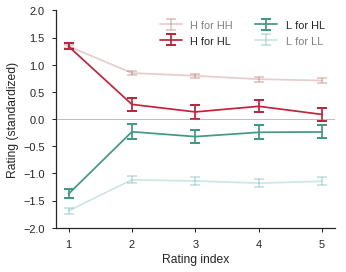

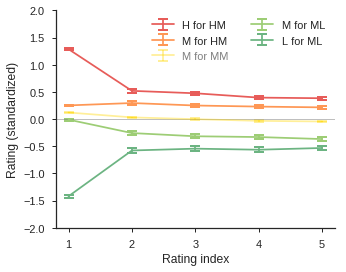

In [10]:
with open(data_folder + 'prepared/herding.json', 'r') as infile:
    vals = json.load(infile)
vals['L for ML'] = vals['L for LM']
vals['M for ML'] = vals['M for LM']

for type_class in ['extreme', 'medium']:

    plt.figure(figsize=(5, 4), frameon=False)

    sns.set_context("paper")
    sns.set(font_scale = 1.1)
    sns.set_style("white", {
        "font.family": "sans-serif",
        "font.serif": ['Helvetica'],
        "font.scale": 2
    })
    sns.set_style("ticks", {"xtick.major.size": 4,
                            "ytick.major.size": 4})
    
    ax = plt.subplot(111)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    if type_class == 'extreme':
        classes_to_plot = ['H for HH','H for HL', 'L for HL', 'L for LL']

        vals_class = [0, 3]

    elif type_class == 'medium':  
        classes_to_plot = ['H for HM', 'M for HM', 'M for MM', 'M for ML', 'L for ML']

        vals_class = [2]

    i = 0
    for class_ in classes_to_plot:

        vals_tmp = vals[class_]

        avg = np.array(vals_tmp['avg'])
        high = np.array(vals_tmp['high'])
        low = np.array(vals_tmp['low'])

        if i in vals_class:
            if type_class == 'extreme':
                alpha = 0.2
            else:
                alpha = 0.4
        else:
            alpha = 1

        plt.errorbar(range(1, min_nbr_rats + 1), avg, yerr=[high-avg, avg-low],
                    fmt='-', ms=4, capsize=5, capthick=2, c=colors[class_], 
                     alpha=alpha, label = class_) 

        i+=1

    l = plt.legend(ncol=2)
    plt.xticks(list(range(1,min_nbr_rats + 1)))

    i = 0
    for text in l.get_texts():
        if i in vals_class:
            text.set_color('gray')
        i+=1
        
    plt.plot([-2, min_nbr_rats + 2], [0, 0], color='grey', linewidth=0.5)

    plt.ylim([-2, 2])
    plt.ylabel('Rating (standardized)')

    plt.xlim([0.8, min_nbr_rats + 0.2])

    plt.xlabel('Rating index')
    
    plt.savefig(fig_folder + 'herding_{}_{}.pdf'.format(type_class, 'global'), bbox_inches='tight')

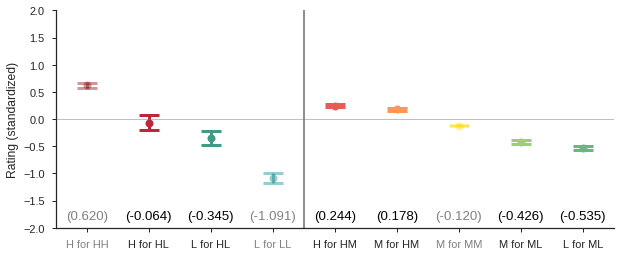

In [11]:
with open(data_folder + 'prepared/herding_lta.json', 'r') as infile:
    vals_lta = json.load(infile)
    
classes_names = ['H for HH',
 'H for HL',
 'L for HL',
 'L for LL',
 'H for HM',
 'M for HM',
 'M for MM',
 'M for ML',
 'L for ML']

plt.figure(figsize=(10, 4), frameon=False)

sns.set_context("paper")
sns.set(font_scale = 1.1)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

vals_class = [0, 3, 6]

avg = np.array(vals_lta['avg'])
low = np.array(vals_lta['low'])
high = np.array(vals_lta['high'])

text_ticks = []
for i in range(len(avg)):

    if i in vals_class:
        if type_class == 'extreme':
            alpha = 0.2
        else:
            alpha = 0.4
    else:
        alpha = 1

    plt.errorbar(i, avg[i], yerr=[[high[i]-avg[i]], [avg[i]-low[i]]], 
                fmt='o', markersize=8, capsize=10, capthick=3, lw=3,
                 c=colors[classes_names[i]], alpha=alpha)

    text_ticks.append(classes_names[i])# + '\n({:.3f})\n'.format(avg[i]))

plt.xlim([-0.5, len(text_ticks)-0.5])
plt.xticks(list(range(len(text_ticks))), text_ticks)

i=0
for xtick in ax.xaxis.get_ticklabels():

    if i in vals_class:
        xtick.set(color='gray')

    i+=1
    
for i in range(len(avg)):
    
    c = 'k'
    if i in vals_class:
        c='gray'
    
    ax.text(i, -1.9, '({:.3f})'.format(avg[i]), 
    horizontalalignment='center', verticalalignment='bottom', color=c)


plt.plot([-0.5, len(text_ticks)-0.5], [0, 0], color='grey', linewidth=0.5)

plt.plot([3.5, 3.5], [-2, 2], 'grey')

plt.ylim([-2, 2])
plt.ylabel('Rating (standardized)')
plt.xlabel('I love beers!', color='w')

plt.savefig(fig_folder + 'lta_herding_{}.pdf'.format('global'), bbox_inches='tight')